<a href="https://colab.research.google.com/github/ChrisFJardine/Masterclass/blob/main/CJardineAssignment3__SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import re
import time
import datetime
import os
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn
import statistics as stat
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()


%matplotlib inline 
from datetime import datetime, timedelta

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load the output from the crawler
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/ExtractedNews.csv', header = None)

In [4]:
#tidy the dataframe
docs = []
for x in range(news.shape[1]):
  for y in range(news.shape[0]):
    if isinstance(news[x][y], str):
      docs.append(news[x][y])
df = pd.DataFrame(docs)

In [5]:
#tokenise a doc into sentences then return the average sentiment score for all sentences 
def get_avg_sent(doc):
  x = []
  for sent in  nltk.sent_tokenize(doc):
    x.append(sid.polarity_scores(sent)['compound'])
  return(stat.mean(x))
  

In [6]:
#Clean the corpus.
df = pd.DataFrame(docs)
df['date'] = df[0].apply(lambda x: datetime.strptime(re.search(r'\d{4}-\d{2}-\d{2}', str(x)).group(),'%Y-%m-%d').date())
df['text'] = df[0].str.replace('[^\w\s]', '')       #Strip punctuation
df['text'] = df['text'].str.replace('\d+','')       #Strip numbers
df['text'] = df['text'].str.lstrip()                #Strip leading space
df['text'] = df['text'].str.lower()                 #to lower case
df.sort_values(by='date', inplace=True)


In [7]:
#Get compound sentiment of each document    
df['sentiment'] = df.apply(lambda x: sid.polarity_scores(x.text), axis=1)
df['doc_sentiment']  = df['sentiment'].apply(lambda score_dict: score_dict['compound'])


In [8]:
#get compound sentiment of each sentence and average for the document.
df['sentence_text'] = df[0]
df['sentence_text'] = df['sentence_text'].str[16:]
df['tokenised_avg_sentiment'] = df.apply(lambda x: get_avg_sent(x.sentence_text), axis = 1)
df = df.drop(df.columns[[0]], 1)


In [ ]:
#Check the numeric data
df.describe()

,doc_sentiment,tokenised_avg_sentiment
count,95457.000000,95457.000000
mean,-0.062872,-0.050456
std,0.510997,0.469140
min,-0.994600,-0.989100
25%,-0.493900,-0.416200
50%,0.000000,0.000000
75%,0.361200,0.296000
max,0.985800,0.980100


In [ ]:
#dataframe overview
print(df.shape)
print(min(df.date))
print(max(df.date))


(95457, 7)
2011-01-01
2021-11-26


In [9]:
#Create 'words' version with stopwords removed.
stop = stopwords.words('english')
additional_stopwords = ['australia','australian','grandstand','grandstands','australias'] 
for word in additional_stopwords:
  stop.append(word)
df['words'] = df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))


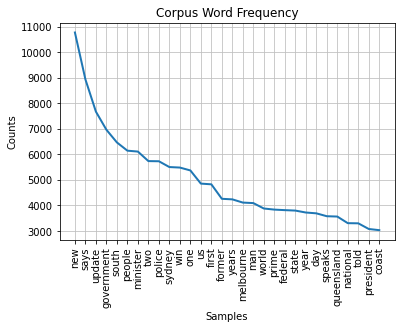

In [ ]:
#Visualise the corpus in a Frequency chart
listwords = ' '.join([x for x in df.words]).split()
fdist = FreqDist(listwords)
fdist.plot(30, cumulative = False, title = 'Corpus Word Frequency' )

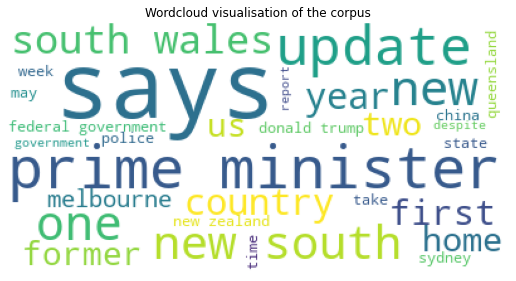

In [ ]:
#and a word cloud
text = " ".join(word for word in listwords)
wordcloud = WordCloud(max_words = 30, background_color="white").generate(text)
plt.figure(figsize = [9,9])
plt.imshow(wordcloud, interpolation='antialiased')
plt.title('Wordcloud visualisation of the corpus')
plt.axis("off")
plt.show()

In [10]:
#Get mean sentiment per day
df_grouped = df.groupby('date').mean()

In [13]:
df_grouped.head
df_grouped.to_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/df_grouped_sentiment.csv', index=True) 

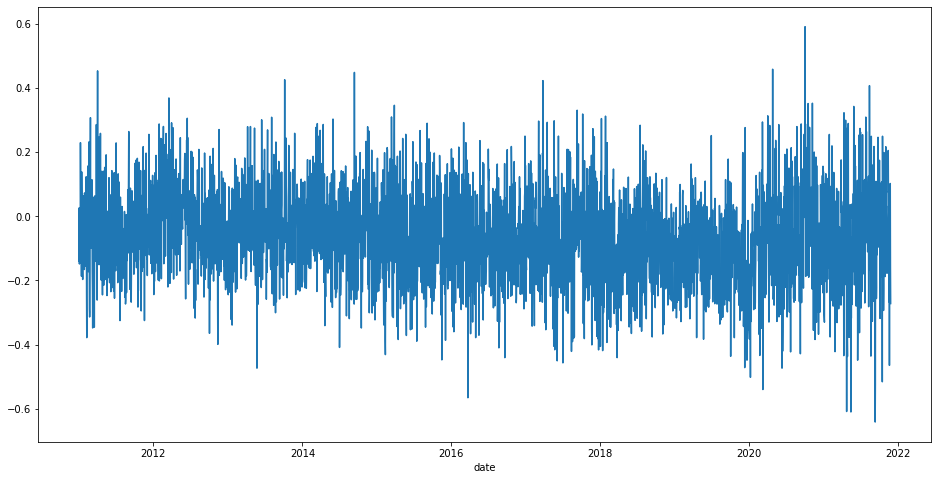

In [ ]:
#Visualise average sentiment.
df_grouped['doc_sentiment'].plot(figsize = (16,8))
#Too many data points.

In [ ]:
#Create a rolling 30 day average
df_grouped['rolling_doc_sentiment'] = df_grouped['doc_sentiment'].rolling(window=30).mean() 
df_grouped['rolling_tokenised_avg_sentiment'] = df_grouped['tokenised_avg_sentiment'].rolling(window=30).mean()

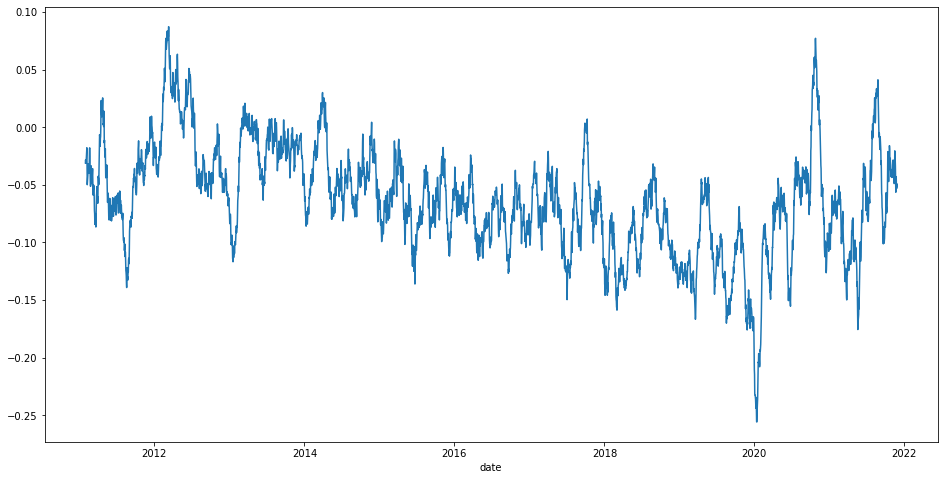

In [ ]:
#Visualise the sentiment
df_grouped['rolling_doc_sentiment'].plot(figsize = (16,8))

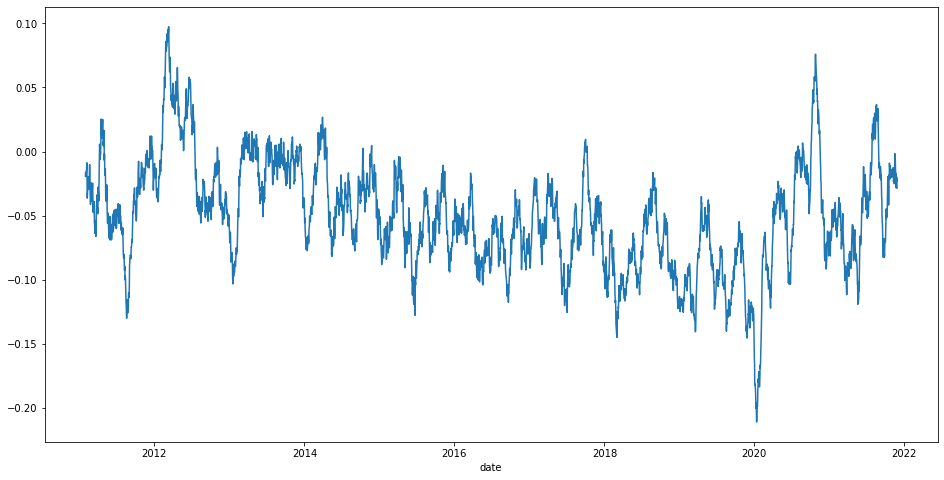

In [ ]:
#Visualise sentence tokenised sentiment. - same same
df_grouped['rolling_tokenised_avg_sentiment'].plot(figsize = (16,8))

In [ ]:
#Investigate peak in 2012 and 2019
df2012 = df[( df['date'] > pd.Timestamp(2012,1,1))  &  (df['date'] < pd.Timestamp(2013,1,1)) ] 
listwords2012 = ' '.join([x for x in df2012.words]).split()

df2019 = df[( df['date'] > pd.Timestamp(2019,1,1))  &  (df['date'] < pd.Timestamp(2020,1,1)) ] 
listwords2019 = ' '.join([x for x in df2019.words]).split()


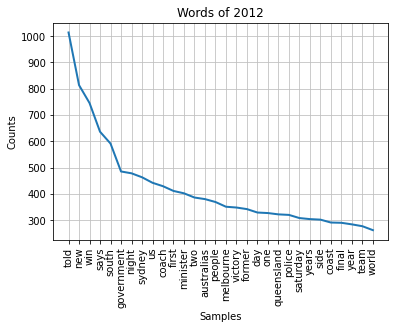

In [ ]:
fdist = FreqDist(listwords2012)
fdist.plot(30, cumulative = False, title = 'Words of 2012' )

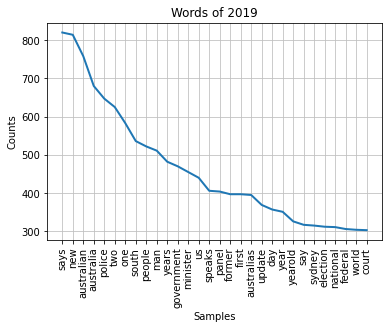

In [ ]:
fdist = FreqDist(listwords2019)
fdist.plot(30, cumulative = False, title = 'Words of 2019')

In [ ]:
#Load Cricket data. Wrangle dates and calculate a momentum score based on average wins over last 10 matches
cricket = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/AusCricketResults.csv')
cricket = cricket.dropna()
cricket[['days','year']] = cricket['Match Date'].str.split(',', expand = True)
cricket[['test_start', 'test_end']] = cricket['days'].str.split('-', expand = True)
cricket['test_date'] = cricket['test_start']  + cricket['year']
cricket['test_date'] = pd.to_datetime(cricket['test_date'])
cricket.drop(['days', 'year', 'test_start','test_end'], axis=1, inplace=True)
cricket['score'] = 0
cricket.loc[cricket['Winner'] == 'Australia', 'score' ] = 1  
cricket['momentum'] = cricket['score'].rolling(window=10).mean()


In [ ]:
#Join the cricket data with the sentiment analysed corpus
crick_trend =  cricket[['test_date','momentum']].fillna(0)
crick_trend['test_date'] = pd.to_datetime(crick_trend['test_date'])
crick_trend = crick_trend.set_index('test_date')
crick_trend = crick_trend['2011-01-01':'2021-11-26']
data = df_grouped.join(crick_trend)

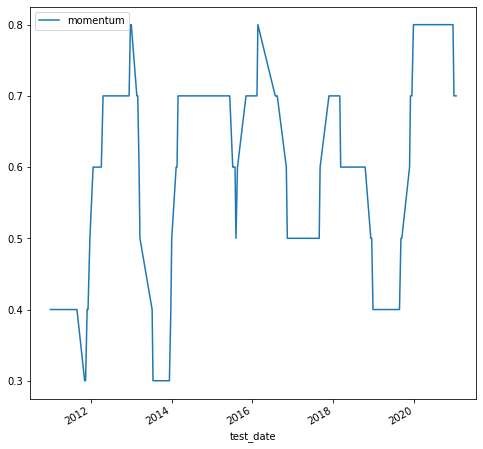

In [ ]:
#Visualise momentum of the Baggy Green
crick_trend.plot(figsize = (8,8))


In [ ]:
#Manually add the momentum for the first record and fill momentum for dates with no cricket on.
data.iloc[0]['momentum'] = 0.4
data['momentum'] = data['momentum'].fillna(method='ffill')
data = data.fillna(0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Normalise the sentiment and the cricket momentum
plotdata = data[['rolling_doc_sentiment','momentum']]
cols_to_norm = ['rolling_doc_sentiment','momentum']
plotdata[cols_to_norm] = plotdata[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


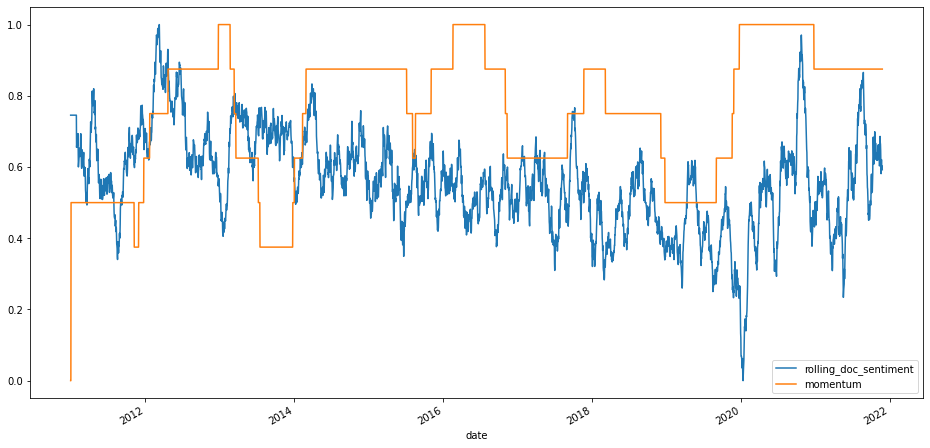

In [ ]:
#What does this even look like?!
plotdata.plot(figsize = (16,8))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


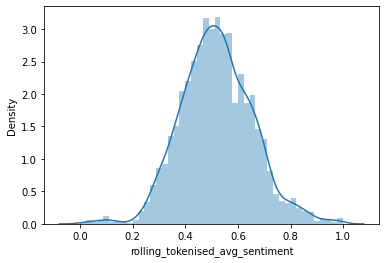

In [ ]:
seaborn.distplot(data['rolling_doc_sentiment'])

In [ ]:
#Try a regression model
data = data.fillna(0)                                               #remove na
y = data['rolling_doc_sentiment']                                   #target value
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 0)  #test / train split
regressor = LinearRegression()                                      #Linear reg model
regressor.fit(train_X, train_y)                                     #fit the model
y_pred = regressor.predict(test_X)                                  #And predict

results = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})


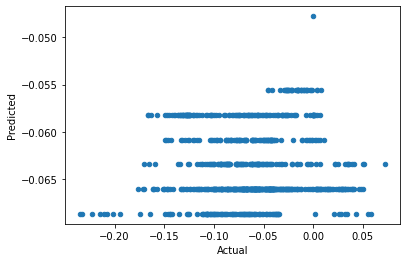

In [ ]:
#Scatter plot results
results.plot.scatter( x = 'Actual', y = 'Predicted')

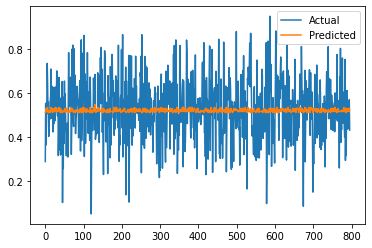

In [ ]:
#Plot actual vs predicted
results.plot()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))
print('Deviation of target: ', np.std(y_pred) )


Mean Absolute Error: 0.037233400262672876
Mean Squared Error: 0.0023506465135282235
Root Mean Squared Error: 0.04848346639348535
Deviation of target:  0.0038348859621126982


In [ ]:
#Pearson correlation close to 0. Not correlated.
data['momentum'].corr(data['rolling_doc_sentiment'])


-0.07752529301311947

In [ ]:
#So what were the happy times?
happy_times = df[df['compound'] > .98]
sad_times = df[df['compound'] < -.9925 ]

In [ ]:
#Happy times :D
pd.set_option('display.max_colwidth', None)
for text in happy_times['text']:
  print(text.lstrip())

shes the stoic enduring face of the struggle against military rule in her poor and brutally oppressed country persistently pushing against the heavy hand of the junta her dignified perseverance  even during years of house arrest  has made aung san suu kyi a towering figure of inspiration at home and abroad but at  is the nobel peace prize winner and democracy icon still the best hope for freedom in burma after a risky path to her front door we find aung san suu kyi expansive candid and resolute but time is passing and genuine change seems as far away as ever
bryce courtenay was one of australias best loved authors but it was a character he created that was possibly his best seller the yowie an australian chocolate for kids was also cadburys top selling product in the nineties but it was pulled from the shelves a decade ago after a copyright dispute now the yowie is being remoulded it is seeing sweet success in the united states where its biggest rival the kinder surprise is locked out


In [ ]:
#Sad times :(
for text in sad_times['text']:
  print(text.lstrip())

burma has pardoned hundreds of prisoners under an amnesty criticised by prodemocracy activists as a cynical ploy to curry favour before a landmark visit by us president barack obama officials said  prisoners would walk free but most or all of them appeared to be ordinary criminals rights groups said they were not aware of the release of any of the scores of dissidents still in jail the assistance association for political prisoners aapp a thailandbased campaign group described the pardon as the worst amnesty to date burma has already freed hundreds of political prisoners incarcerated by the former junta as part of reforms that have led to a dramatic thaw in relations between the onetime pariah nation and the west campaigners including new yorkbased human rights watch cast doubt on the motivation for the latest amnesty it seems there is a new game in burma which is the political prisoners game said hrw deputy asia director phil robertson calling the release cynical and lacking in transp